In [26]:
# Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import io
import contextlib
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')
from src.config import (
    SEED, DATA_DIR, FIGURES_DIR,
    ID_COL, TARGET_COL, CLAIM_NB_COL, EXPOSURE_COL,
    CATEGORICAL_FEATURES, NUMERICAL_FEATURES, ALL_FEATURES,
    ORDINAL_FEATURES, NOMINAL_FEATURES, AREA_ORDER
)
from src.utils import evaluate_regression, print_metrics
from src.neural_network import NeuralNetwork

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

np.random.seed(SEED)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"Setup complete. Seed: {SEED}")


Setup complete. Seed: 42


In [27]:
# Data loading and preparation
df_train = pd.read_csv(DATA_DIR / 'claims_train.csv')
df_test = pd.read_csv(DATA_DIR / 'claims_test.csv')

# Data cleaning: remove observations with Exposure > 1 (invalid data)
df_train = df_train[df_train[EXPOSURE_COL] <= 1].copy()

# Create target variable: ClaimFrequency = ClaimNb / Exposure
df_train[TARGET_COL] = df_train[CLAIM_NB_COL] / df_train[EXPOSURE_COL]
df_test[TARGET_COL] = df_test[CLAIM_NB_COL] / df_test[EXPOSURE_COL]

# Prepare features and target
X_train_full_raw = df_train[ALL_FEATURES]
y_train_full = df_train[TARGET_COL].values
X_test_raw = df_test[ALL_FEATURES]
y_test = df_test[TARGET_COL].values

# Setup 5-fold cross-validation (test set held out for final evaluation)
K_FOLDS = 5
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

print(f"Train: {len(df_train):,} samples, Test: {len(df_test):,} samples")
print(f"Target: mean={y_train_full.mean():.4f}, std={y_train_full.std():.4f}, max={y_train_full.max():.1f}")

Train: 541,416 samples, Test: 135,603 samples
Target: mean=0.2616, std=4.4322, max=732.0


In [28]:
# Preprocessing setup
# - Scale numerical features (StandardScaler)
# - Ordinal encode ordinal features (Area: A < B < ... < F)
# - One-hot encode nominal features (VehBrand, VehGas, Region)
# NOTE: Preprocessing fitted within each CV fold to prevent data leakage

def create_preprocessor():
    """Create a fresh preprocessor for each CV fold"""
    return ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), NUMERICAL_FEATURES),
            ('ord', OrdinalEncoder(categories=[AREA_ORDER]), ORDINAL_FEATURES),
            ('nom', OneHotEncoder(drop='first', sparse_output=False), NOMINAL_FEATURES)
        ]
    )

# Get feature count
temp_preprocessor = create_preprocessor()
temp_X = temp_preprocessor.fit_transform(X_train_full_raw)
n_features = temp_X.shape[1]

print(f"Features: {X_train_full_raw.shape[1]} → {n_features} (after encoding)")

Features: 9 → 38 (after encoding)


In [29]:
# FROM-SCRATCH NEURAL NETWORK WITH 5-FOLD CROSS-VALIDATION

def cv_neural_network(X_df, y, layer_sizes, learning_rate, epochs, batch_size, kfold, silent=True):
    """
    Perform k-fold CV for from-scratch neural network.
    Preprocessing fitted within each fold to prevent data leakage.
    """
    cv_scores = {'R2': [], 'RMSE': [], 'MAE': [], 'MSE': []}
    cv_times = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_df)):
        X_tr_raw, X_vl_raw = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_tr, y_vl = y[train_idx], y[val_idx]
        
        # Preprocess within fold
        preprocessor = create_preprocessor()
        X_tr = preprocessor.fit_transform(X_tr_raw)
        X_vl = preprocessor.transform(X_vl_raw)
        
        # Create and train model (suppress verbose output)
        if silent:
            with contextlib.redirect_stdout(io.StringIO()):
                model = NeuralNetwork(
                    layer_sizes=layer_sizes, learning_rate=learning_rate,
                    epochs=epochs, batch_size=batch_size,
                    hidden_activation='relu', random_seed=SEED
                )
                start = time.time()
                model.fit(X_tr, y_tr, verbose=0)
                cv_times.append(time.time() - start)
        else:
            model = NeuralNetwork(
                layer_sizes=layer_sizes, learning_rate=learning_rate,
                epochs=epochs, batch_size=batch_size,
                hidden_activation='relu', random_seed=SEED
            )
            start = time.time()
            model.fit(X_tr, y_tr, verbose=0)
            cv_times.append(time.time() - start)
        
        # Evaluate
        y_pred = model.predict(X_vl)
        metrics = evaluate_regression(y_vl, y_pred)
        for key in cv_scores:
            cv_scores[key].append(metrics[key])
    
    return {k: (np.mean(v), np.std(v)) for k, v in cv_scores.items()}, np.mean(cv_times), model

# Baseline: default architecture [38, 32, 16, 1]
print("FROM-SCRATCH NN: 5-Fold CV")
print("Running... ", end="", flush=True)
cv_results_scratch, avg_time_scratch, last_model_scratch = cv_neural_network(
    X_train_full_raw, y_train_full,
    layer_sizes=[n_features, 32, 16, 1],
    learning_rate=0.001, epochs=50, batch_size=128, kfold=kfold
)
print("done.")
print(f"  MAE: {cv_results_scratch['MAE'][0]:.4f} ± {cv_results_scratch['MAE'][1]:.4f}")
print(f"  RMSE: {cv_results_scratch['RMSE'][0]:.4f} ± {cv_results_scratch['RMSE'][1]:.4f}")
print(f"  Time: {avg_time_scratch:.2f}s/fold")

FROM-SCRATCH NN: 5-Fold CV
Running... done.
  MAE: 0.4808 ± 0.0407
  RMSE: 4.4021 ± 0.4173
  Time: 29.71s/fold


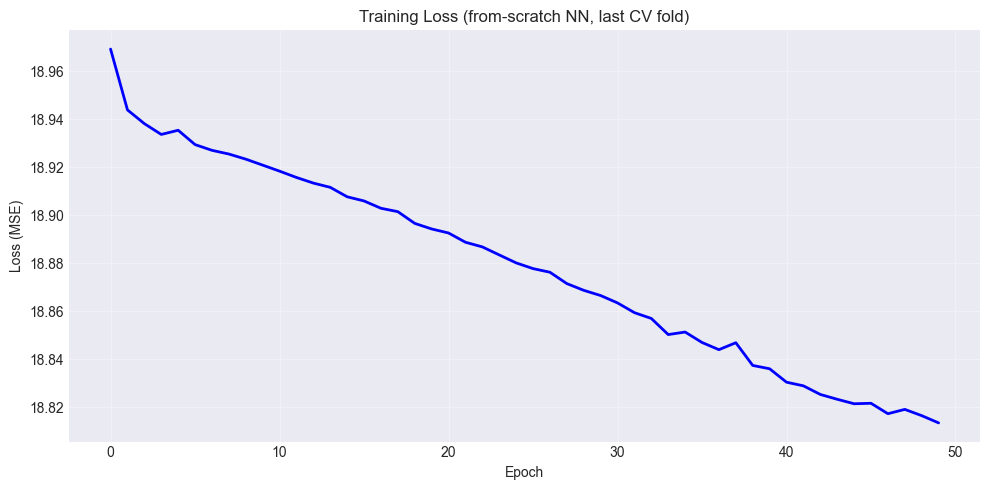

Loss: 18.9692 → 18.8134 (0.8% reduction)


In [30]:
# Training loss plot (from last CV fold)
plt.figure(figsize=(10, 5))
plt.plot(last_model_scratch.loss_history, linewidth=2, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss (from-scratch NN, last CV fold)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'nn_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Loss analysis
init_loss = last_model_scratch.loss_history[0]
final_loss = last_model_scratch.loss_history[-1]
pct_reduction = (init_loss - final_loss) / init_loss * 100
print(f"Loss: {init_loss:.4f} → {final_loss:.4f} ({pct_reduction:.1f}% reduction)")

In [31]:
# SKLEARN MLPRegressor WITH 5-FOLD CROSS-VALIDATION

def cv_sklearn_nn(X_df, y, hidden_layers, learning_rate, max_iter, batch_size, kfold):
    """
    Perform k-fold CV for sklearn MLPRegressor.
    Preprocessing fitted within each fold to prevent data leakage.
    """
    cv_scores = {'R2': [], 'RMSE': [], 'MAE': [], 'MSE': []}
    cv_times = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_df)):
        X_tr_raw, X_vl_raw = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_tr, y_vl = y[train_idx], y[val_idx]
        
        # Preprocess within fold
        preprocessor = create_preprocessor()
        X_tr = preprocessor.fit_transform(X_tr_raw)
        X_vl = preprocessor.transform(X_vl_raw)
        
        # Create and train model
        model = MLPRegressor(
            hidden_layer_sizes=hidden_layers, activation='relu', solver='adam',
            learning_rate_init=learning_rate, max_iter=max_iter,
            batch_size=batch_size, random_state=SEED, verbose=False, early_stopping=False
        )
        
        start = time.time()
        model.fit(X_tr, y_tr)
        cv_times.append(time.time() - start)
        
        # Evaluate
        y_pred = model.predict(X_vl)
        metrics = evaluate_regression(y_vl, y_pred)
        for key in cv_scores:
            cv_scores[key].append(metrics[key])
    
    return {k: (np.mean(v), np.std(v)) for k, v in cv_scores.items()}, np.mean(cv_times), model

# Sklearn baseline with same architecture
print("SKLEARN MLPRegressor: 5-Fold CV")
print("Running... ", end="", flush=True)
cv_results_sklearn, avg_time_sklearn, last_model_sklearn = cv_sklearn_nn(
    X_train_full_raw, y_train_full,
    hidden_layers=(32, 16), learning_rate=0.001, max_iter=50, batch_size=128, kfold=kfold
)
print("done.")
print(f"  MAE: {cv_results_sklearn['MAE'][0]:.4f} ± {cv_results_sklearn['MAE'][1]:.4f}")
print(f"  RMSE: {cv_results_sklearn['RMSE'][0]:.4f} ± {cv_results_sklearn['RMSE'][1]:.4f}")
print(f"  Time: {avg_time_sklearn:.2f}s/fold")

SKLEARN MLPRegressor: 5-Fold CV
Running... done.
  MAE: 0.5437 ± 0.0647
  RMSE: 4.4536 ± 0.3813
  Time: 71.80s/fold


In [32]:
# COMPARISON: From-Scratch vs Sklearn
print("COMPARISON: From-Scratch vs Sklearn")
comparison_df = pd.DataFrame({
    'Model': ['From-Scratch', 'Sklearn'],
    'MAE_mean': [cv_results_scratch['MAE'][0], cv_results_sklearn['MAE'][0]],
    'MAE_std': [cv_results_scratch['MAE'][1], cv_results_sklearn['MAE'][1]],
    'RMSE_mean': [cv_results_scratch['RMSE'][0], cv_results_sklearn['RMSE'][0]],
    'Time_s': [avg_time_scratch, avg_time_sklearn]
})
print(comparison_df.to_string(index=False))

# Note on differences
mae_diff = cv_results_scratch['MAE'][0] - cv_results_sklearn['MAE'][0]
print(f"\nMAE diff (scratch-sklearn): {mae_diff:.6f}")
# Differences due to optimization (SGD vs Adam) and implementation details.

COMPARISON: From-Scratch vs Sklearn
       Model  MAE_mean  MAE_std  RMSE_mean    Time_s
From-Scratch  0.480809 0.040732   4.402127 29.712741
     Sklearn  0.543699 0.064702   4.453613 71.800684

MAE diff (scratch-sklearn): -0.062890


In [33]:
# HYPERPARAMETER TUNING (5-Fold CV) - Sequential Search
# Stage 1: Find best architecture (fix lr=0.001, epochs=100)
# Stage 2: Fix best architecture [64,32], vary learning rate
# Stage 3: Fix best (architecture, lr), vary epochs
# Using MAE for selection as it's more robust to outliers than R².
configs = [
    # Stage 1: Vary architecture (fix lr=0.001, epochs=100)
    {'name': 'Wider [64,32]', 'arch': [n_features, 64, 32, 1], 'lr': 0.001, 'epochs': 100},
    {'name': 'Deeper [32,32,16]', 'arch': [n_features, 32, 32, 16, 1], 'lr': 0.001, 'epochs': 100},
    {'name': 'Very Wide [128,64]', 'arch': [n_features, 128, 64, 1], 'lr': 0.001, 'epochs': 100},
    
    # Stage 2: Vary learning rate (fix best arch=[64,32], epochs=100)
    {'name': 'LR 0.01 [64,32]', 'arch': [n_features, 64, 32, 1], 'lr': 0.01, 'epochs': 100},
    {'name': 'LR 0.0001 [64,32]', 'arch': [n_features, 64, 32, 1], 'lr': 0.0001, 'epochs': 100},
    
    # Stage 3: Vary epochs (fix best arch=[64,32], lr=0.001)
    {'name': 'Epochs 200 [64,32]', 'arch': [n_features, 64, 32, 1], 'lr': 0.001, 'epochs': 200},
]

print(f"HYPERPARAMETER TUNING: {len(configs)} configurations (sequential search)")

HYPERPARAMETER TUNING: 6 configurations (sequential search)


In [34]:
# Run hyperparameter tuning (selecting by MAE)
results = []
for i, cfg in enumerate(configs, 1):
    print(f"[{i}/{len(configs)}] {cfg['name']}... ", end="", flush=True)
    cv_res, avg_t, _ = cv_neural_network(
        X_train_full_raw, y_train_full,
        layer_sizes=cfg['arch'], learning_rate=cfg['lr'],
        epochs=cfg['epochs'], batch_size=128, kfold=kfold
    )
    results.append({
        'Config': cfg['name'], 'Architecture': str(cfg['arch']),
        'LR': cfg['lr'], 'Epochs': cfg['epochs'],
        'MAE_mean': cv_res['MAE'][0], 'MAE_std': cv_res['MAE'][1],
        'RMSE_mean': cv_res['RMSE'][0], 'RMSE_std': cv_res['RMSE'][1],
        'Time_s': avg_t * K_FOLDS
    })
    print(f"MAE={cv_res['MAE'][0]:.4f}±{cv_res['MAE'][1]:.4f}")

print("\nTuning complete.")

[1/6] Wider [64,32]... MAE=0.4672±0.0358
[2/6] Deeper [32,32,16]... MAE=0.4915±0.0442
[3/6] Very Wide [128,64]... MAE=0.5865±0.0995
[4/6] LR 0.01 [64,32]... MAE=0.4726±0.0496
[5/6] LR 0.0001 [64,32]... MAE=0.4943±0.0118
[6/6] Epochs 200 [64,32]... MAE=0.4937±0.0388

Tuning complete.


In [35]:
# Display tuning results (sorted by MAE, lower is better)
results_df = pd.DataFrame(results).sort_values('MAE_mean', ascending=True)
print("CV RESULTS (sorted by MAE, lower is better):")
print(results_df[['Config', 'MAE_mean', 'MAE_std', 'RMSE_mean', 'Time_s']].to_string(index=False))

# Best configuration
best = results_df.iloc[0]
print(f"\nBest: {best['Config']}")
print(f"  MAE: {best['MAE_mean']:.4f} ± {best['MAE_std']:.4f}")
print(f"  RMSE: {best['RMSE_mean']:.4f} ± {best['RMSE_std']:.4f}")

CV RESULTS (sorted by MAE, lower is better):
            Config  MAE_mean  MAE_std  RMSE_mean     Time_s
     Wider [64,32]  0.467184 0.035817   4.404997 655.010719
   LR 0.01 [64,32]  0.472561 0.049607   4.415373 166.776881
 Deeper [32,32,16]  0.491492 0.044176   4.411270 313.303178
Epochs 200 [64,32]  0.493650 0.038814   4.436562 336.451185
 LR 0.0001 [64,32]  0.494342 0.011785   4.408581 161.197710
Very Wide [128,64]  0.586507 0.099463   4.425126 238.499113

Best: Wider [64,32]
  MAE: 0.4672 ± 0.0358
  RMSE: 4.4050 ± 0.4161


In [36]:
# FINAL MODEL TRAINING
# Train on full training set with best hyperparameters from CV
best_arch = eval(best['Architecture'])
best_lr = best['LR']
best_epochs = int(best['Epochs'])

print("FINAL MODEL TRAINING")
print(f"Best config: {best['Config']}")
print(f"  Architecture: {best_arch}, LR: {best_lr}, Epochs: {best_epochs}")

# Fit preprocessor on full training data
preprocessor_final = create_preprocessor()
X_train_full = preprocessor_final.fit_transform(X_train_full_raw)
X_test = preprocessor_final.transform(X_test_raw)

# Train final model
final_nn = NeuralNetwork(
    layer_sizes=best_arch, learning_rate=best_lr,
    epochs=best_epochs, batch_size=128,
    hidden_activation='relu', random_seed=SEED
)
start_time = time.time()
final_nn.fit(X_train_full, y_train_full, verbose=1)
print(f"\nTraining time: {time.time() - start_time:.2f}s")

FINAL MODEL TRAINING
Best config: Wider [64,32]
  Architecture: [38, 64, 32, 1], LR: 0.001, Epochs: 100
NEURAL NETWORK INITIALIZED
Architecture: 38 → 64 → 32 → 1
  Input layer:  38 features
  Hidden layer 1: 64 neurons (relu)
  Hidden layer 2: 32 neurons (relu)
  Output layer: 1 neuron(s) (linear)

Hyperparameters:
  Learning rate: 0.001
  Epochs:        100
  Batch size:    128
  Random seed:   42

TRAINING STARTED
Training samples: 541,416
Batch size: 128
Batches per epoch: 4,230
Total epochs: 100
Epoch  10/100, Loss: 19.601321
Epoch  20/100, Loss: 19.558910
Epoch  30/100, Loss: 19.527006
Epoch  40/100, Loss: 19.493696
Epoch  50/100, Loss: 19.475161
Epoch  60/100, Loss: 19.447183
Epoch  70/100, Loss: 19.425644
Epoch  80/100, Loss: 19.410012
Epoch  90/100, Loss: 19.381286
Epoch 100/100, Loss: 19.359318

TRAINING COMPLETED
Final loss: 19.359318
Initial loss: 19.638482
Improvement: 0.279163

Training time: 43.11s


In [ ]:
# FINAL MODEL EVALUATION
y_train_pred = final_nn.predict(X_train_full)
y_test_pred = final_nn.predict(X_test)

train_metrics = evaluate_regression(y_train_full, y_train_pred)
test_metrics = evaluate_regression(y_test, y_test_pred)

print("FINAL MODEL EVALUATION")
print("\nTraining set:")
print_metrics(train_metrics, "Train")
print("\nTest set (held out):")
print_metrics(test_metrics, "Test")

# Generalization gap
r2_gap = train_metrics['R2'] - test_metrics['R2']
print(f"\nGeneralization gap (R² train-test): {r2_gap:.6f}")

FINAL MODEL EVALUATION

Training set:

Train Performance:
  MSE       : 19.290132
  RMSE      : 4.392053
  MAE       : 0.464543
  R2        : 0.018016

Test set (held out):

Test Performance:
  MSE       : 26.890534
  RMSE      : 5.185608
  MAE       : 0.480554
  R2        : 0.007258

Generalization gap (R² train-test): 0.010759
